# MNIST Example

## Training

### Loading the dataset

In [3]:
import torch
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as v2
from torchvision.models import resnet18, resnet50
from trainer import GenericTrainer
from metrics import accuracy

# To open the tensorboard summary run this command in your cmd inside your conda environment : 
# tensorboard --logdir=xxxx --port=xxxx (Fill in the xxxx, port can be 8080 for example)

# Some parameters to be set for training
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch_size = 64
epochs = 25
max_grad_norm = 10
n_mimo_inputs = 3 # Only needed if MIMO networks are used otherwise set to -1

# Setup transformations for the inputs and labels
transform = v2.Compose([v2.PILToTensor(), v2.ToDtype(torch.float32), v2.Normalize(mean=(33.3285,), std=(78.5655,))]) # MNIST training dataset mean and std
target_transform = lambda x:F.one_hot(torch.tensor(x), num_classes=10).float()

# Only needed for MIMO networks, creates multiple inputs for each element in the batch
def mimo_collate(batch):
    batch_size = len(batch)
    assert batch_size >= n_mimo_inputs, "Batch size needs to be bigger or equal to the number of MIMO ensembles."
    mimo_indices = torch.arange(batch_size).unsqueeze(1).repeat(1, n_mimo_inputs)
    mimo_indices[:, 1:] = torch.randint(low=0, high=batch_size, size=(batch_size, n_mimo_inputs-1)) # Randomly choose the elements in the batch to cat together
    
    data = torch.stack([item[0] for item in batch], dim=0) # Shape : batch_size x channels x height x width
    target = torch.stack([item[1] for item in batch], dim=0) # Shape : batch_size x num_classes

    x = torch.stack([data[mimo_indices[i, :], ...] for i in range(batch_size)], dim=0)
    y = torch.stack([target[mimo_indices[i, :], ...] for i in range(batch_size)], dim=0)
    return x, y

# Setup the dataset and dataloaders
training_dataset = MNIST(root=r"../data/raw", train=True, download=True, transform=transform, target_transform=target_transform)
training_loader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, collate_fn=mimo_collate if n_mimo_inputs > 1 else None)

if(n_mimo_inputs > 1): # Unsqueeze one dimension at the beginning for the MIMO convention
    transform = v2.Compose([v2.PILToTensor(), v2.ToDtype(torch.float32), v2.Normalize(mean=(33.3285,), std=(78.5655,)), lambda x:x.unsqueeze(0)])
    target_transform = lambda x:F.one_hot(torch.tensor(x), num_classes=10).float().unsqueeze(0).repeat(n_mimo_inputs, 1)

val_dataset = MNIST(root=r"../data/raw", train=False, download=True, transform=transform, target_transform=target_transform)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

### Starting the training run

In [ ]:
from models import MIMOModel
# Setup the model and change its input channels from 3 (RGB) to 1 (Grayscale)

if(n_mimo_inputs <= 1):
    # Typical resnet18
    model = resnet18(num_classes=10)
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) # There is unfortunately no external way to change the input channel size
    model = model.to(device)
else:
    # MIMO resnet50
    model = resnet50(num_classes=10)
    model.conv1 = torch.nn.Conv2d(n_mimo_inputs, 64, kernel_size=7, stride=2, padding=3, bias=False) # There is unfortunately no external way to change the input channel size
    model.fc = torch.nn.Linear(2048, 10*n_mimo_inputs) # Expand output size as well
    model = MIMOModel(n_inputs=n_mimo_inputs, base_model=model.to(device))

# Setup optimizer and scheduler
optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer=optimizer, factor=1., total_iters=epochs)

# Setup loss and metrics
loss = lambda x,y : torch.nn.CrossEntropyLoss()(x.view(-1, x.shape[-1]), y.view(-1, y.shape[-1])) # Lambda sorcery is needed for MIMO
metrics = {"Accuracy" : accuracy}

# Setup the trainer and train
trainer = GenericTrainer(device=device, model=model, loss=loss, metrics=metrics, optimizer=optimizer, scheduler=scheduler, 
                        max_grad_norm=max_grad_norm, fp16_precision=True, log_every_n_steps=25, save_every_n_epochs=5, 
                        epochs=epochs, seed=42, verbose=True)
trainer.train(training_loader, val_loader)

## Visualizing the results

### Normal model

In [15]:
import torch
from torchvision.models import resnet18

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
path_to_model = r"runs\Dec08_23-06-51_DESKTOP-K6APQCL\checkpoint_00010.pt" # Example path, replace with your own
checkpoint = torch.load(path_to_model) # Load the checkpoint

# Setup the model and change its input channels from 3 (RGB) to 1 (Grayscale)
model = resnet18(num_classes=10)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) # There is unfortunately no external way to change the input channel size
model.load_state_dict(checkpoint["state_dict"]) # Load the model weights into the newly initialized model
model = model.to(device)
model = model.eval()

C:\Users\JadHa\AppData\Local\Temp\ipykernel_1672\867369364.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_model) # Load the checkpoint


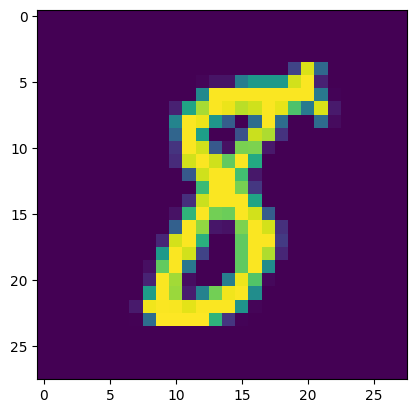

Label : tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), argmax: 8
Prediction : [3.15e-10 1.36e-10 7.43e-11 1.30e-08 2.73e-10 1.39e-06 1.11e-09 9.84e-11
 1.00e+00 2.39e-09], argmax: 8


In [16]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=2)

idx = 125
image, label = training_dataset[idx]
with torch.no_grad():
    prediction = torch.softmax(model(image.to(device).unsqueeze(0)), dim=-1).cpu().numpy()

plt.imshow(image.numpy().squeeze())
plt.show()
print(f"Label : {label}, argmax: {label.argmax(dim=-1)}\nPrediction : {prediction.flatten()}, argmax: {prediction.argmax(axis=-1)[0]}")

### MIMO

In [5]:
import torch
from torchvision.models import resnet50
from models import MIMOModel

n_mimo_inputs = 3
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
path_to_model = r"runs\Dec12_11-17-04_Work_PC_Jad\checkpoint_00010.pt" # Example path, replace with your own
checkpoint = torch.load(path_to_model) # Load the checkpoint

model = resnet50(num_classes=10)
model.conv1 = torch.nn.Conv2d(n_mimo_inputs, 64, kernel_size=7, stride=2, padding=3, bias=False) # There is unfortunately no external way to change the input channel size
model.fc = torch.nn.Linear(2048, 10*n_mimo_inputs) # Expand output size as well
model:torch.nn.Module = MIMOModel(n_inputs=n_mimo_inputs, base_model=model.to(device))

model.load_state_dict(checkpoint["state_dict"]) # Load the model weights into the newly initialized model
model = model.to(device)
model = model.eval()

C:\Users\haida\AppData\Local\Temp\ipykernel_20720\373233684.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_model) # Load the checkpoint


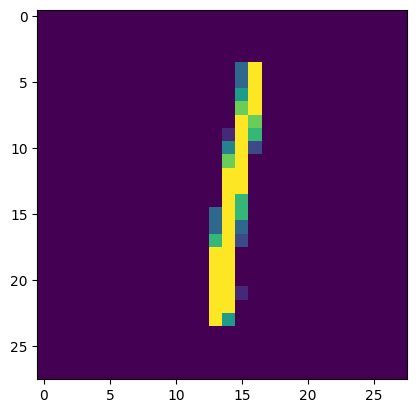

Label : tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'), argmax: 1
Submodel 0 Prediction : [6.94e-24 1.00e+00 6.07e-11 4.73e-24 2.31e-09 3.15e-28 3.82e-22 2.74e-19
 2.48e-32 6.85e-26], argmax: 1
Submodel 1 Prediction : [5.54e-25 1.00e+00 1.97e-16 3.61e-23 3.84e-17 3.17e-20 3.75e-24 8.26e-20
 1.30e-27 4.98e-21], argmax: 1
Submodel 2 Prediction : [1.39e-07 1.78e-01 1.24e-09 2.35e-16 8.18e-01 1.51e-08 2.19e-12 2.52e-04
 3.47e-03 1.27e-09], argmax: 4


In [28]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=2)

transform = v2.Compose([v2.PILToTensor(), v2.ToDtype(torch.float32), v2.Normalize(mean=(33.3285,), std=(78.5655,)), lambda x:x.unsqueeze(0)])
target_transform = lambda x:F.one_hot(torch.tensor(x), num_classes=10).float().unsqueeze(0).repeat(n_mimo_inputs, 1)

val_dataset = MNIST(root=r"../data/raw", train=False, download=True, transform=transform, target_transform=target_transform)
val_loader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=True, pin_memory=True)

for data, labels in val_loader:
    data:torch.Tensor = data.to(device)
    labels:torch.Tensor = labels.to(device)

    with torch.no_grad():
        predictions = torch.softmax(model(data.to(device)), dim=-1).cpu().numpy().squeeze() # Shape : 1 x n_mimo_inputs x num_classes
        predictions_amax = predictions.argmax(axis=-1)
        if(np.any(predictions_amax != predictions_amax[0])):
            break

plt.imshow(data.cpu().numpy().squeeze())
plt.show()
print(f"Label : {labels.squeeze()[0, ...]}, argmax: {labels.squeeze()[0, ...].argmax(dim=-1)}")
for i in range(predictions.shape[0]):
    print(f"Submodel {i} Prediction : {predictions[i, ...].flatten()}, argmax: {predictions[i, ...].argmax(axis=-1)}")


# TUSZ Example

## Visualizing the data

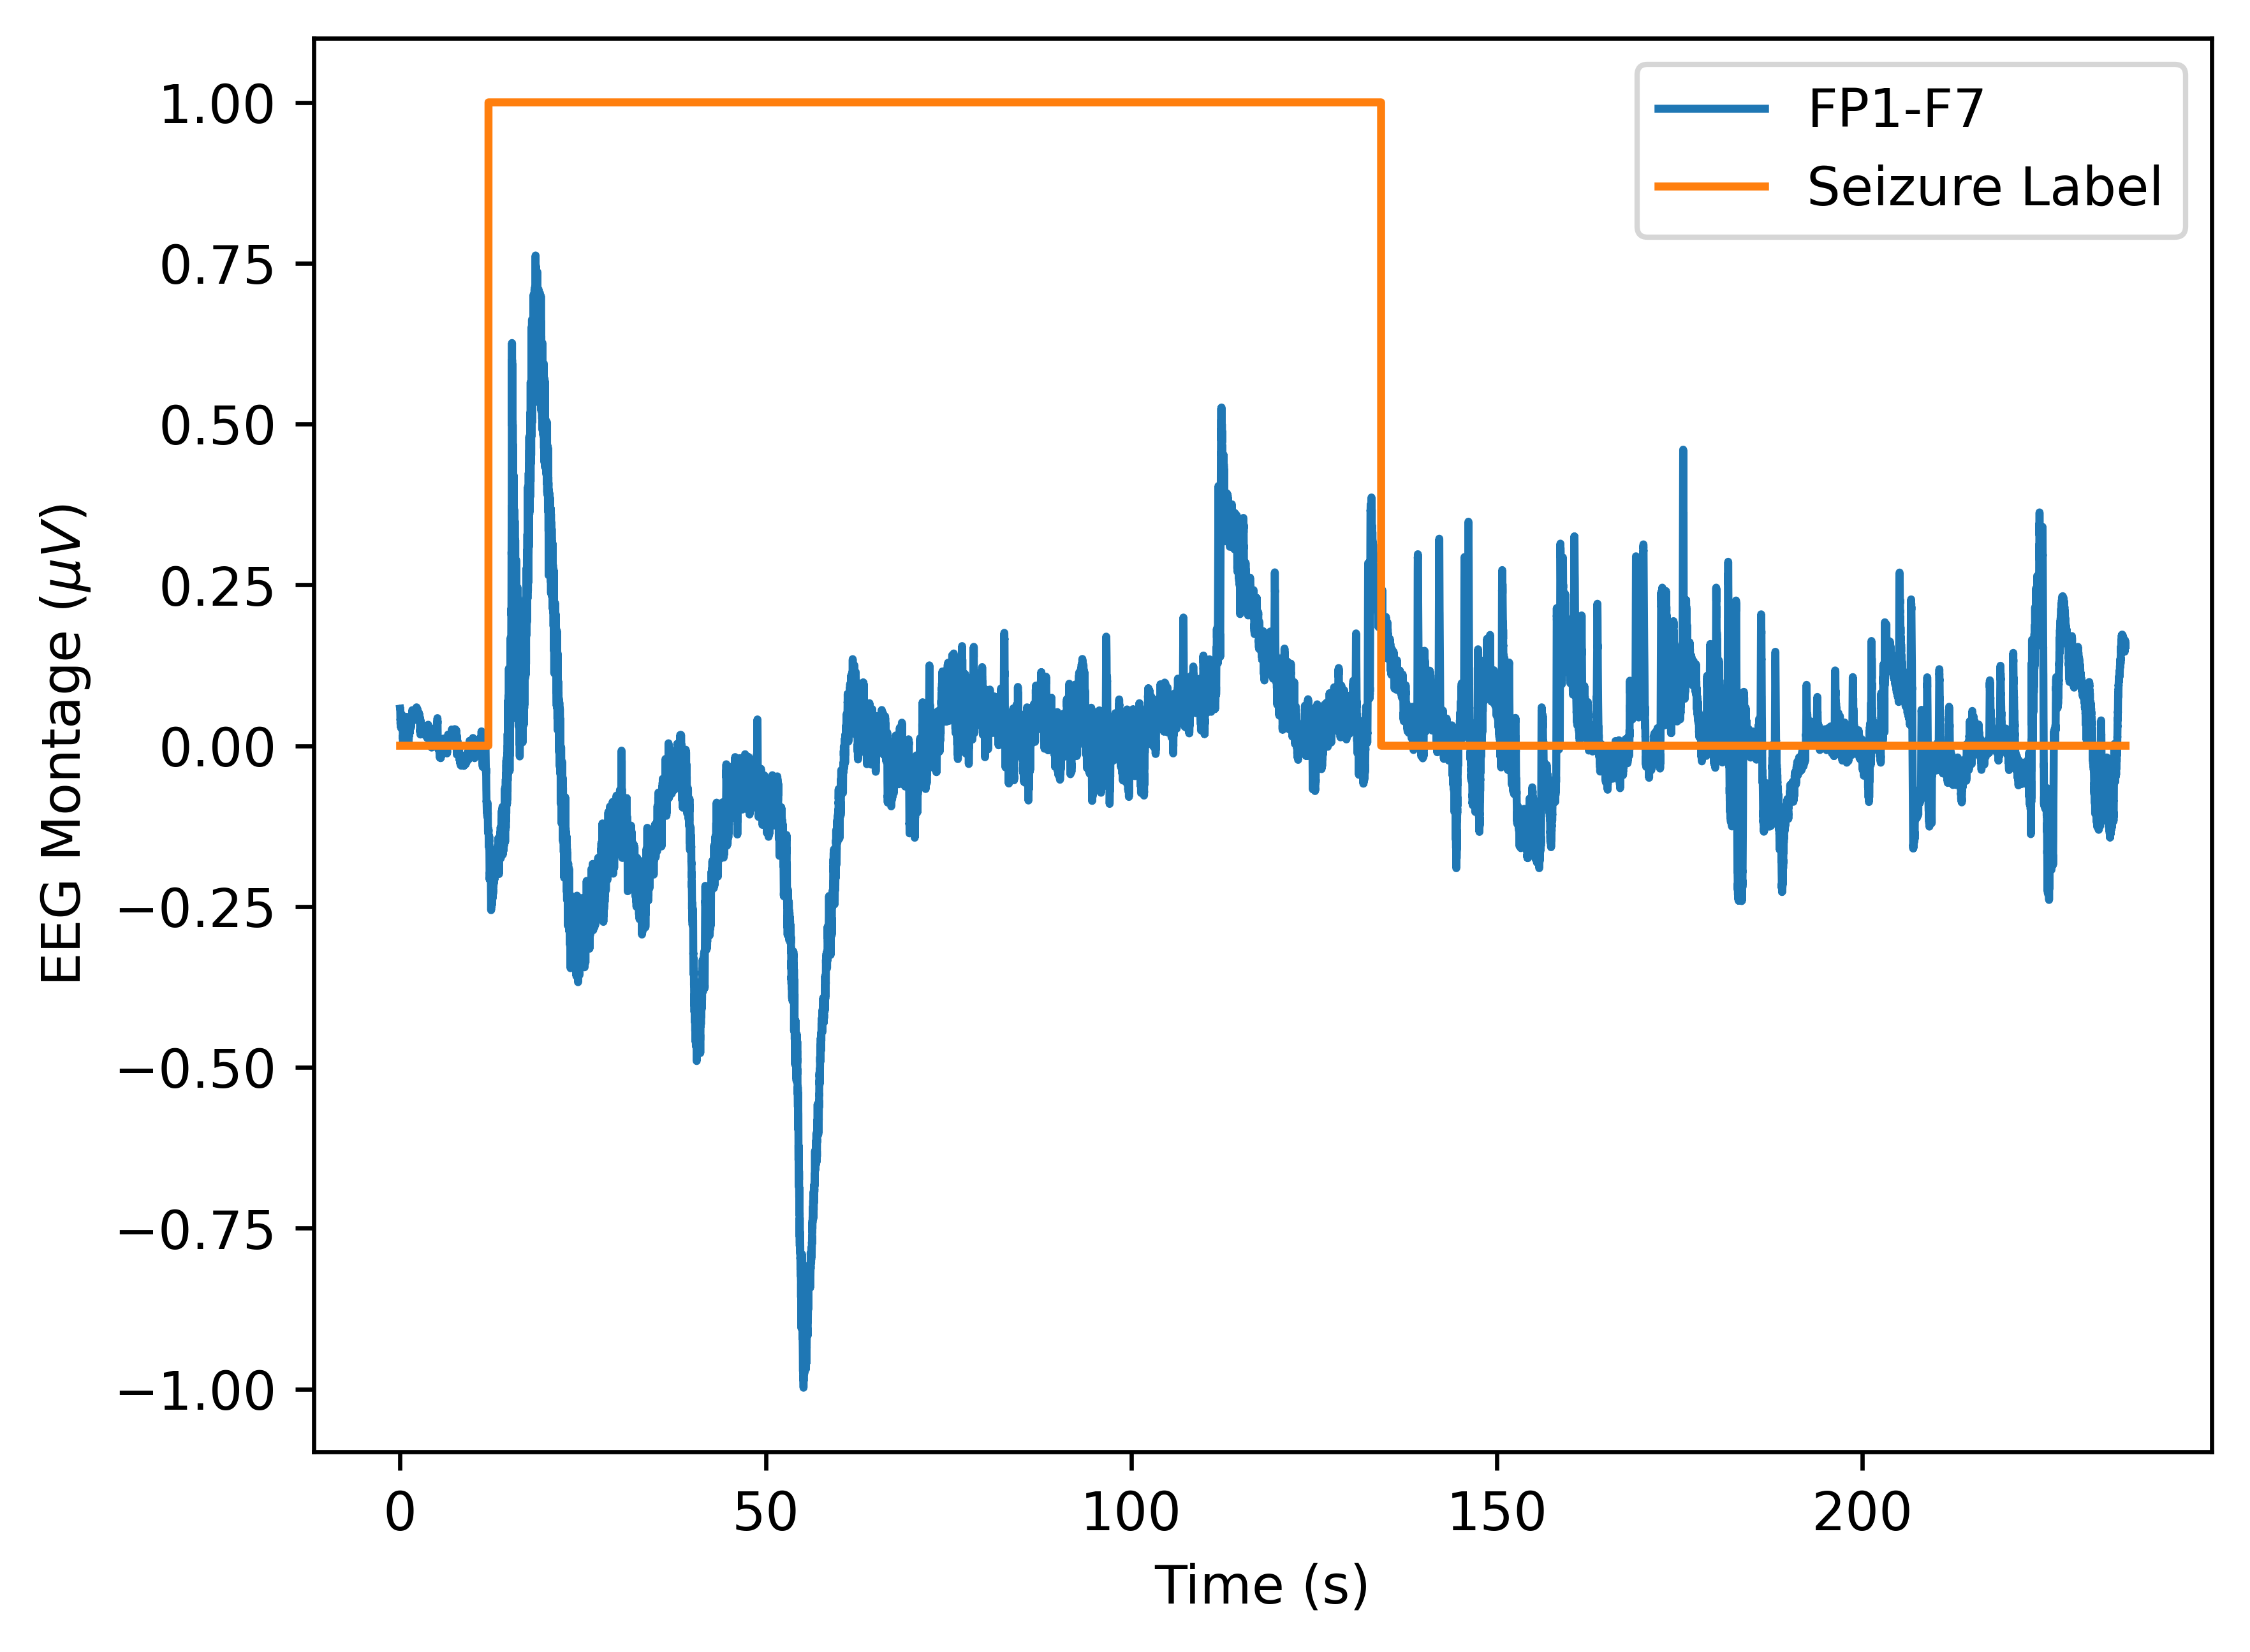

In [2]:
from tusz_utilities import get_montages_from_edf, generate_label_TUSZ
import matplotlib.pyplot as plt
import numpy as np

edf_path = r"T:\TUH EEG Seizure Corpus\edf\train\aaaaaaac\s001_2002_12_23\02_tcp_le\aaaaaaac_s001_t001.edf" # Change accordingly
montages, fs, montage_names = get_montages_from_edf(edf_path) # Montages shape : N_montages x N_datapoints

montages = (montages - montages.mean(axis=-1, keepdims=True)) / (np.abs(montages).max(axis=-1, keepdims=True)) # Normalize to [-1, 1] range for visualization

# Get labels for unsegmented data
label_path = edf_path.replace(".edf", ".csv")
labels = generate_label_TUSZ(label_path, montages.shape[-1], montages.shape[0], fs, 1, montage_names) # Shape : N_datapoints x N_montages

t = np.arange(montages.shape[-1])/fs # Get time axis
montage_idx = 0

plt.figure(dpi=600)
plt.plot(t, montages[montage_idx, :], label=montage_names[montage_idx])
plt.plot(t, labels[:, montage_idx], label="Seizure Label") # 0 = normal, 1 = seizure
plt.xlabel("Time (s)")
plt.ylabel(r"EEG Montage ($\mu V$)") # Example of how to use LaTeX in Python
plt.legend()
plt.show()

# MIMIC-IV Example

## Visualizing the data

62.4725
20 seconds of data extracted from segment 83404654_0005


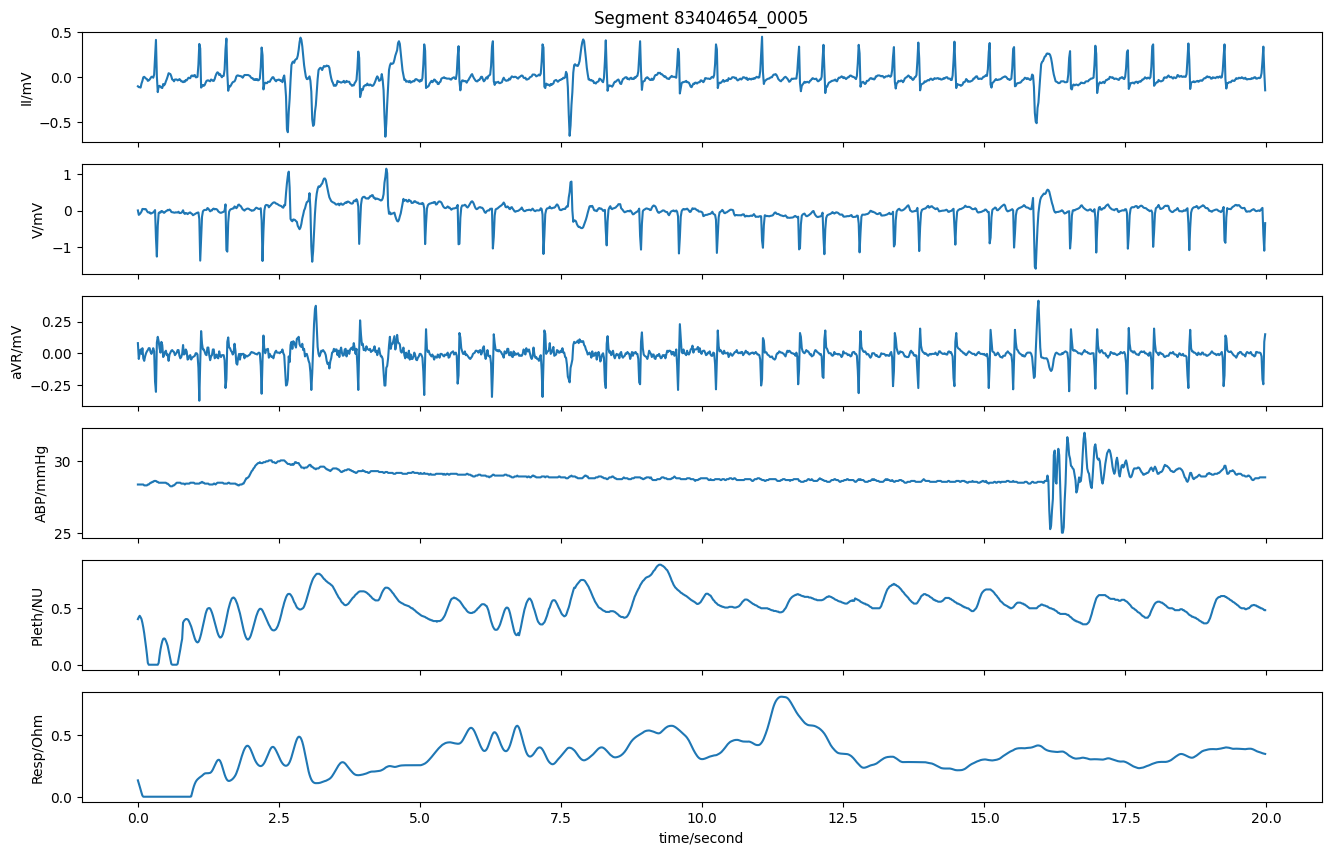

In [29]:
import wfdb
import matplotlib.pyplot as plt
import os

dataset_path = r"C:\Users\haida\Desktop\Uni\Datasets\physionet.org\files" # Change accordingly
segment_names = ['83404654_0005', '82924339_0007']
segment_dirs = ['mimic4wdb/0.1.0/waves/p100/p10020306/83404654',
                'mimic4wdb/0.1.0/waves/p101/p10126957/82924339']
idx = 0

segment_metadata = wfdb.rdheader(record_name=os.path.join(dataset_path, segment_dirs[idx], segment_names[idx]))
fs = segment_metadata.fs
print(f"The signals' sampling rate is {fs} Hz")

start_seconds = 35
n_seconds_to_load = 20

sampfrom = int(fs * start_seconds)
sampto = int(fs * (start_seconds + n_seconds_to_load))

rec = wfdb.rdrecord(record_name=os.path.join(dataset_path, segment_dirs[idx], segment_names[idx]),
                             sampfrom=sampfrom,
                             sampto=sampto)

print(f"{n_seconds_to_load} seconds of data extracted from segment {segment_names[idx]}")

wfdb.plot_wfdb(record=rec,
               title=f"Segment {segment_names[idx]}",
               time_units='seconds',
               figsize=(16, 10)) 

# PTBXL Example

## Visualizing the data

The signals' sampling rate is 500 Hz
10 seconds of data extracted from segment HR00001


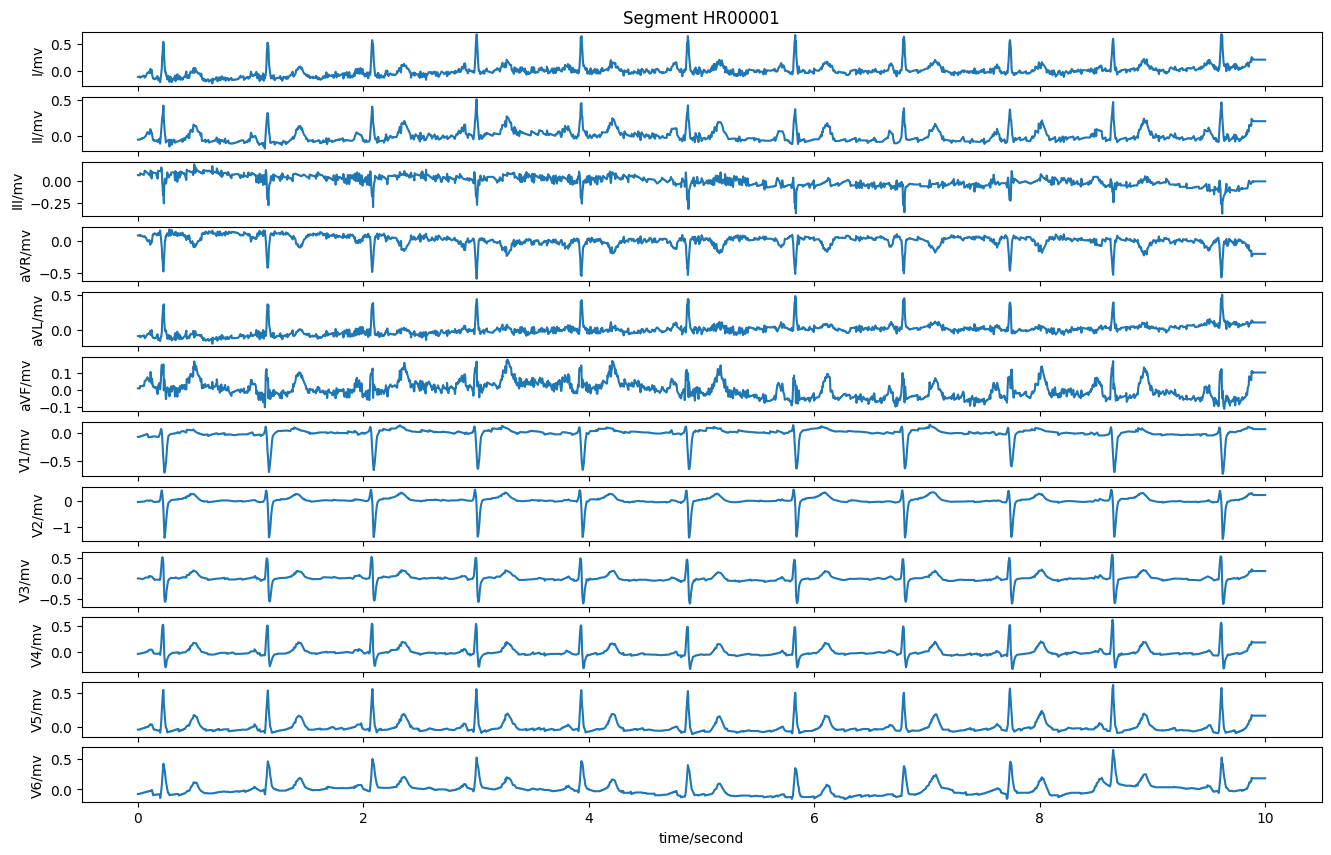

In [7]:
import wfdb
import matplotlib.pyplot as plt
import os

dataset_path = r"P:\CINC_2021\Data\WFDB_PTBXL" # Change accordingly
segment_names = ['HR00001', 'HR00002']
idx = 0

segment_metadata = wfdb.rdheader(record_name=os.path.join(dataset_path, segment_names[idx]))
fs = segment_metadata.fs
print(f"The signals' sampling rate is {fs} Hz")

start_seconds = 0
n_seconds_to_load = 10

sampfrom = int(fs * start_seconds)
sampto = int(fs * (start_seconds + n_seconds_to_load))

rec = wfdb.rdrecord(record_name=os.path.join(dataset_path, segment_names[idx]),
                             sampfrom=sampfrom,
                             sampto=sampto)

print(f"{n_seconds_to_load} seconds of data extracted from segment {segment_names[idx]}")

wfdb.plot_wfdb(record=rec,
               title=f"Segment {segment_names[idx]}",
               time_units='seconds',
               figsize=(16, 10)) 